In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [247]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.io import fits

In [4]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [6]:
X = np.loadtxt('SN2020jgb_ZTF_g_snr2.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr2.dat')

tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = (tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58969.470214999994 2.992744999999559


In [7]:
tp = 58986.41
z = 0.0307

# Abi's models

## g, r

In [15]:
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')

distmod = 35.66961
leff_g = 4722.74  #AA
leff_r = 6339.61  #AA

In [9]:
import h5py
from matplotlib import cm

In [10]:
def spec_to_flux(spec, flt):
    try:
        wv, fl, sig = spec[:, ~np.isnan(spec[1])]  # synthetic spectrum
    except:
        wv, fl = spec[:, ~np.isnan(spec[1])]
        sig = fl.copy() * .1
    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    fl_flt = np.interp(x=wv_flt, xp=wv, fp=fl)
    var_flt = np.interp(x=wv_flt, xp=wv, fp=sig**2)
    # effective bandwidth
    width = ((wv_flt[1:] - wv_flt[:-1]) * tra_flt[1:]).sum()
    # convolution
    dlambda = wv_flt[1:] - wv_flt[:-1]
    omega = tra_flt[1:] / width * dlambda  # weights
    flux = (fl_flt[1:] * omega).sum()  # erg cm-2 s-1 AA-1
    flux_err = (var_flt[1:] * omega**2).sum()**.5  # erg cm-2 s-1 AA-1
    # effective wavelength
    wv_eff = (wv_flt[1:] * omega).sum()
    flux_Jy = (flux * u.erg / u.cm**2 / u.s / u.AA).to(
        u.Jy, equivalencies=u.spectral_density(wv_eff * u.AA))
    flux_err_Jy = flux_err / flux * flux_Jy
    return flux_Jy.value, flux_err_Jy.value


def spec_to_mag(spec, flt):
    flux, flux_err = spec_to_flux(spec, flt)  # total flux in Jansky

    mag = -2.5 * np.log10(flux / 3631.1)
    mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2
    return mag, mag_unc


In [11]:
def spec_sequence(models, t_rmaxs=[], ebv_gal=0.404, ebv_host=0):
    fig, ax = plt.subplots(1,
                           len(models),
                           figsize=(7 * len(models), 16),
                           sharex=True,
                           sharey=True)
    ax = np.atleast_1d(ax)
    import astropy.constants as const
    # read Abi's models
    if len(t_rmaxs) == 0:
        t_rmaxs = np.ones(len(models)) * 20
    for j, model in enumerate(models):
        with h5py.File(model, 'r') as f:
            mod = model.split('/')[-1]
            mc, ms = mod.split('_')[-3], mod.split('_')[-2]
            Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
            Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
            time = np.array(f['time'][:] / 86400)
            nu = np.array(f['nu'][:])
            wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
            wv = wv0 * (1 + z)
            Flam = np.array([(np.flip(fnu)).to(
                u.erg / u.s / u.cm**2 / u.AA,
                equivalencies=u.spectral_density(wv * u.AA))
                             for fnu in Fnu]) / (1 + z)
            E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=ebv_gal, RV=3.1))
            E_Host = 10**(-0.4 * calALambda(wv=wv, EBV=ebv_host, RV=3.1))
            Flam *= E_Gal * E_Host

        # spectra
        h = 1.15
        t_rmax = t_rmaxs[j]
        for k in range(13):
            arg = np.argmin(abs(time - (k * 2 + 5)))
            spec0 = np.array(
                [wv0[1:], Flam[arg, 1:].ravel(),
                 np.ones_like(wv0[1:])])
            spec = np.array(
                [wv[1:], Flam[arg, 1:].ravel(),
                 np.ones_like(wv[1:])])
            syn_bin = data_binning(spec0.T, size=10)
            ax[j].plot(syn_bin[:, 0],
                       syn_bin[:, 1] / spec_to_flux(spec, P48r)[0] * 1e12 -
                       h * k,
                       color='k',
                       linewidth=2)
            ax[j].text(y=-h * k, x=9400, s='{} d'.format(k * 2 + 5 - t_rmax))
            ax[j].set_title(f'{mc} + {ms}')
    plt.xlim(4100, 10200)
    plt.ylim(-14, 1.5)
    plt.gca().set_yticks([])
    plt.tight_layout()

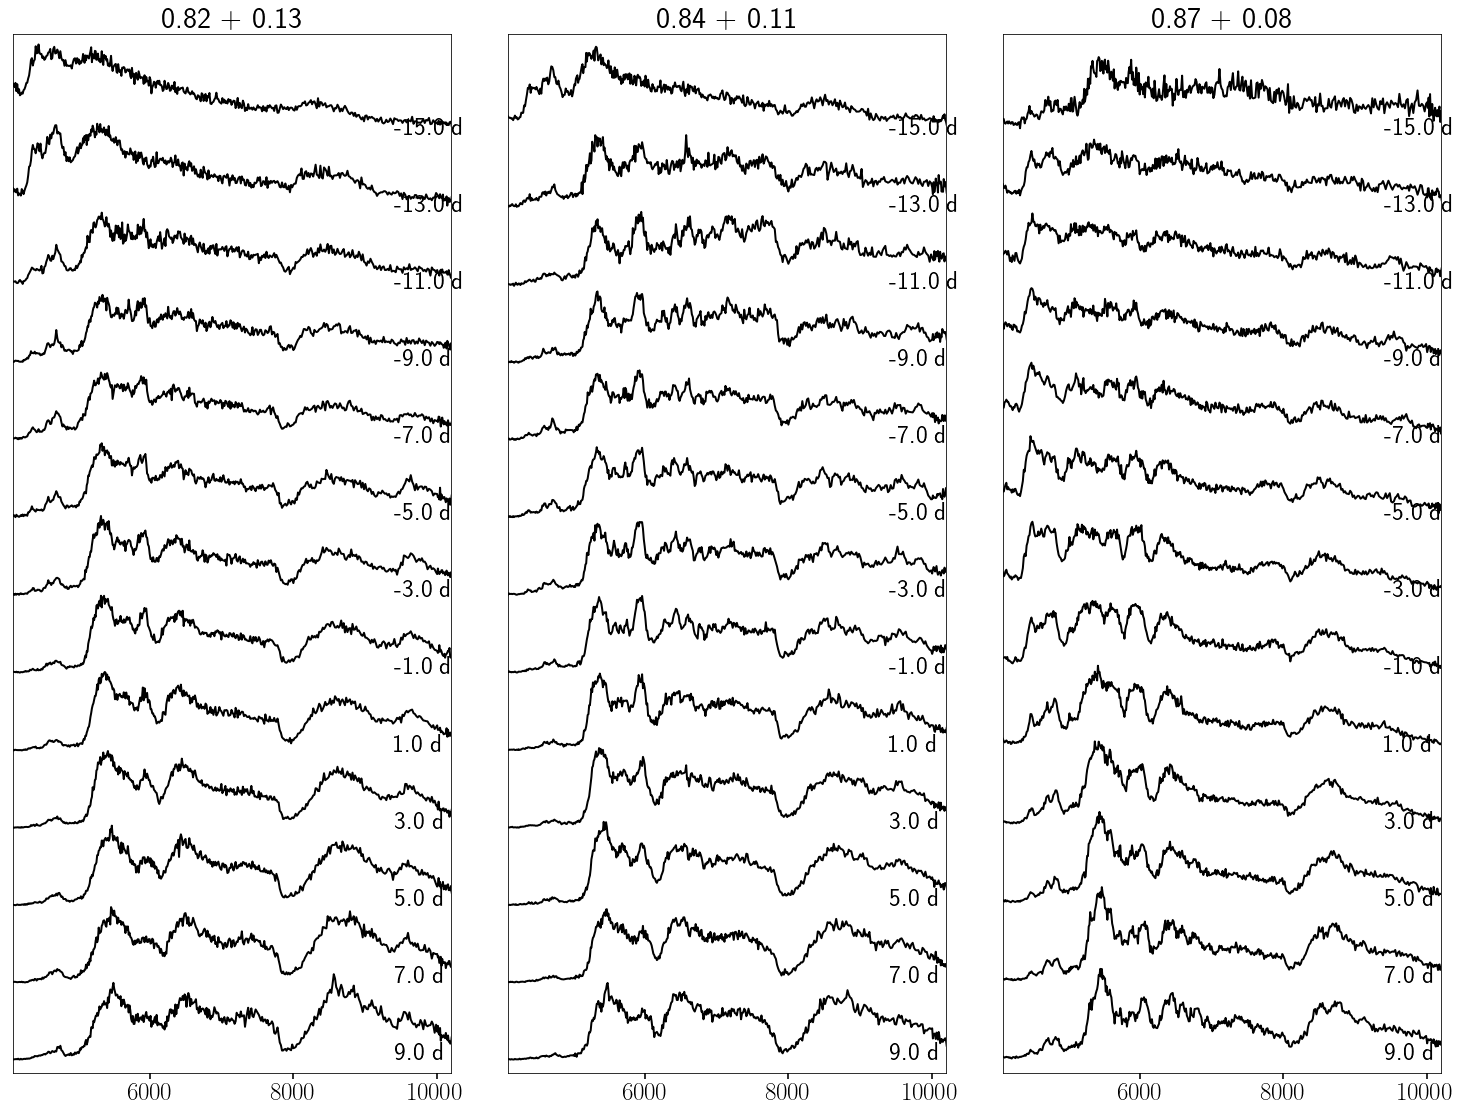

In [16]:
models = glob.glob('../../Mtot0.95/*paper.h5')
models.sort()
spec_sequence(models)


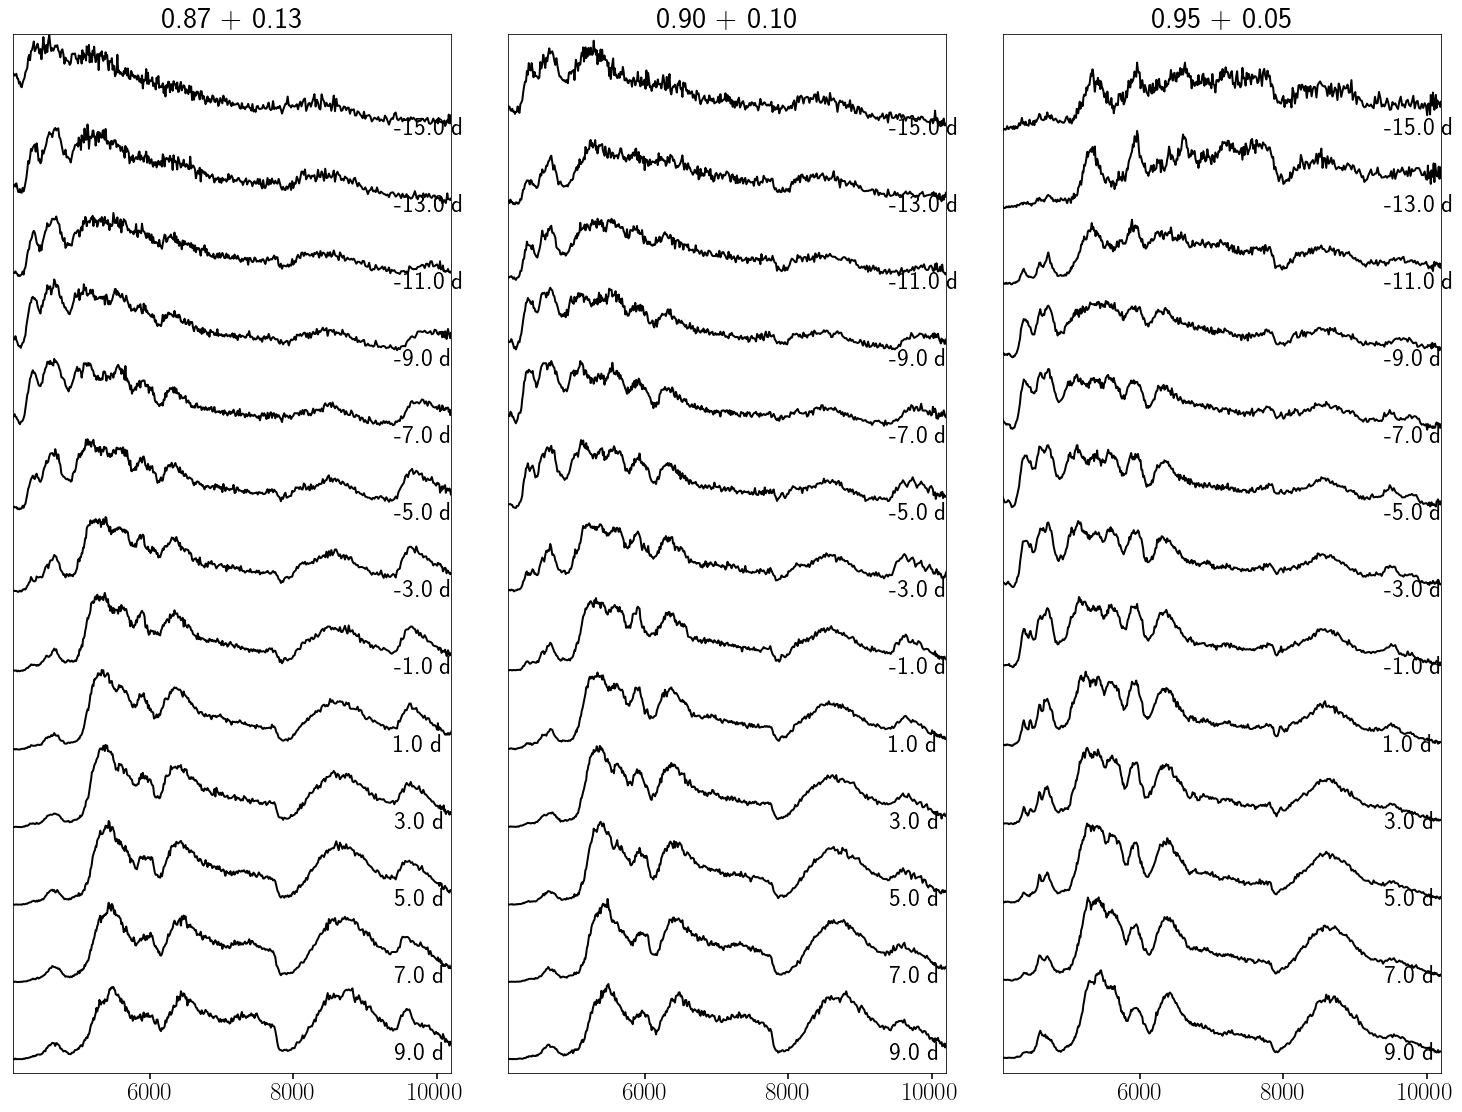

In [17]:
models = glob.glob('../../Mtot1.0/*paper.h5')
models.sort()
spec_sequence(models)


In [216]:
def compare_lc_spec(models,
                    colors,
                    lstyle,
                    ebv_gal=0.404,
                    ebv_host_list=[],
                    h=1.2,
                    t_rmaxs=[], phase_off=[]):
    import astropy.constants as const
    c = 0

    fig = plt.figure(figsize=(16, 10))
    spec = fig.add_gridspec(ncols=2,
                            nrows=2,
                            width_ratios=[6.2, 9.9],
                            height_ratios=[4.45, 4.45])
    ax2, ax1 = fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[:, 1])

    if len(ebv_host_list) == 0:
        ebv_host_list = [0] * len(models)
    if len(phase_off) == 0:
        phase_off = [0] * len(models)

    for c, (model, ebv_host) in enumerate(zip(models, ebv_host_list)):
        # read Abi's models
        if len(t_rmaxs) == 0:
            t_rmaxs = [None] * len(models)
        with h5py.File(model, 'r') as f:
            mod = model.split('/')[-1]
            mc, ms = mod.split('_')[-3], mod.split('_')[-2]
            Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
            Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
            time = np.array(f['time'][:] / 86400)
            nu = np.array(f['nu'][:])
            wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
            wv = wv0 * (1 + z)
            Flam = np.array([(np.flip(fnu)).to(
                u.erg / u.s / u.cm**2 / u.AA,
                equivalencies=u.spectral_density(wv * u.AA))
                             for fnu in Fnu]) / (1 + z)
            E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=ebv_gal, RV=3.1))
            E_Host = 10**(-0.4 * calALambda(wv=wv0, EBV=ebv_host, RV=3.1))
            Flam *= E_Gal * E_Host

        # photometry
        Mag, Mag_unc = np.empty((3, len(time))), np.empty((3, len(time)))
        Fl, Fl_unc = np.empty((3, len(time))), np.empty((3, len(time)))
        T_fl = time
        Flt = [P48g, P48r]
        for j in range(len(time)):
            fl = Flam[j]
            if not (1 < time[j] < 45):
                Mag[:, j], Mag_unc[:, j] = np.nan, np.nan
                Fl[:, j], Fl_unc[:, j] = 0, 0
            else:
                spec = np.array([wv, fl, fl / 100])
                for k in range(2):
                    Mag[k, j], Mag_unc[k, j] = spec_to_mag(spec, Flt[k])
                    Fl[k, j], Fl_unc[k, j] = spec_to_flux(spec, Flt[k])
        g_bin = data_binning(np.array([time, Mag[0],
                                       np.ones_like(time)]).T,
                             size=1)
        r_bin = data_binning(np.array([time, Mag[1],
                                       np.ones_like(time)]).T,
                             size=1)
        t_rmax = r_bin[[np.nanargmin(r_bin[:, 1])], 0]
        if t_rmaxs[c] == None:
            t_rmax_appro = t_rmax + phase_off[c]
        else:
            t_rmax_appro = t_rmaxs[c] + phase_off[c]
        ax1.plot(
            g_bin[:, 0] - t_rmax_appro,  #t_rmax,
            g_bin[:, 1] + distmod,
            linewidth=3,
            color=colors[c],
            linestyle=lstyle[c])
        ax2.plot(
            r_bin[:, 0] - t_rmax_appro,  #t_rmax,
            r_bin[:, 1] + distmod,
            linewidth=3,
            label=r'${}\,$'.format(mc) + r'$\mathrm{M_\odot}$' +
            r'$+{}\,$'.format(ms) + r'$\mathrm{M_\odot},$' +
            r' $E(B-V)_\mathrm{host} = ' + f'{ebv_host}$',
            color=colors[c],
            linestyle=lstyle[c])

        # spectra
        for k in range(2):
            arg = np.argmin(abs(time - (t_rmax_appro + k * 8 - 4)))
            spec0 = np.array(
                [wv0[1:], Flam[arg, 1:].ravel(),
                 np.ones_like(wv0[1:])])
            spec = np.array(
                [wv[1:], Flam[arg, 1:].ravel(),
                 np.ones_like(wv[1:])])
            syn_bin = data_binning(spec0.T, size=20)
            ax3.plot(syn_bin[:, 0],
                     syn_bin[:, 1] / spec_to_flux(spec, P48r)[0] * 1e12 -
                     h * k,
                     color=colors[c],
                     linestyle=lstyle[c],
                     linewidth=3,
                     zorder=10 + (lstyle[c] == '-'))

        print(mc, ms, t_rmax)

    # observed photometry
    ax1.errorbar(
        (tG.ravel() - tp) / (1 + z),
        gmag + distmod + calALambda(wv=leff_g, EBV=ebv_gal, RV=3.1),
        #xerr=2 / (1 + z),
        yerr=gmag_unc,
        fmt='o',
        markersize=10,
        capsize=3,
        markeredgecolor='k',
        markeredgewidth=.5,
        color=color_map['green'])
    ax2.errorbar(
        (tR.ravel() - tp) / (1 + z),
        rmag + distmod + calALambda(wv=leff_r, EBV=ebv_gal, RV=3.1),
        #xerr=2 / (1 + z),
        yerr=rmag_unc,
        fmt='o',
        markersize=10,
        capsize=3,
        markeredgecolor='k',
        markeredgewidth=.5,
        color=color_map['magenta'])
    ax1.set_ylim(18.6, 20.3)
    ax2.set_ylim(17.9, 19.7)
    ax1.set_xlim(-16, 16)
    ax2.set_xlim(-16, 16)
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax2.xaxis.set_ticklabels([])
    ax1.set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
    ax1.set_ylabel('$g_\mathrm{ZTF}\ \mathrm{[mag]}$')
    ax2.set_ylabel('$r_\mathrm{ZTF}\ \mathrm{[mag]}$')
    ax2.legend(loc='lower right', prop={'size': 20-1.5*len(models)})

    # observed spectra
    specs = [
        '../spectroscopy/SN2020jgb/ZTF20aayhacx_20200513_NOT_v4_tell.ascii',
        '../spectroscopy/SN2020jgb/ZTF20aayhacx_20200521_P60_v2.ascii'
    ]
    for k in range(2):
        obs = np.loadtxt(specs[k])
        obs_bin = data_binning(obs, size=10)
        ax3.plot(obs_bin[:, 0] / (1 + z),
                 obs_bin[:, 1] / spec_to_flux(obs.T, P48r)[0] * 1e12 - h * k,
                 color='0.3',
                 linewidth=2,
                 zorder=20)
        if k == 0:
            phase = r'${:.0f}'.format(k * 8 - 4) + r'\ \mathrm{d}$'
        else:
            phase = r'$+{:.0f}'.format(k * 8 - 4) + r'\ \mathrm{d}$'
        ax3.text(8500, -h * (k - 0.12), phase)
    ax3.set_ylabel(r'$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$')
    ax3.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\mathring{A}}]$')
    ax3.set_xlim(3500, 9500)
    ax3.set_ylim(-1.05 * h, 1.09 * h)
    ax3.set_yticks([])
    ax3_obs = ax3.twiny()
    ax3_obs.set_xlim(3500 * (1 + z), 9500 * (1 + z))
    ax3_obs.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\mathring{A}}]$',
                       labelpad=15)

    half_g = P48g[P48g[:, 1] >= P48g[:, 1].max() / 2][:, 0]
    half_g_range = half_g[0], half_g[-1]
    half_r = P48r[P48r[:, 1] >= P48r[:, 1].max() / 2][:, 0]
    half_r_range = half_r[0], half_r[-1]
    ax3_obs.text(s=r'$\mathrm{ZTF}\ g$',
                 x=(half_g[0] + half_g[-1]) / 2,
                 y=h,
                 color=color_map['green'],
                 ha='center',
                 va='center')
    ax3_obs.text(s=r'$\mathrm{ZTF}\ r$',
                 x=(half_r[0] + half_r[-1]) / 2,
                 y=h,
                 color=color_map['magenta'],
                 ha='center',
                 va='center')
    ax3_obs.fill_betweenx(y=ax3.get_ylim(),
                          x1=[half_g_range[0]] * 2,
                          x2=[half_g_range[1]] * 2,
                          color=color_map['green'],
                          alpha=0.1)
    ax3_obs.fill_betweenx(y=ax3.get_ylim(),
                          x1=[half_r_range[0]] * 2,
                          x2=[half_r_range[1]] * 2,
                          color=color_map['magenta'],
                          alpha=0.1)

    for ax in [ax1, ax2]:
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))

    ax3.xaxis.set_minor_locator(MultipleLocator(200))
    ax3_obs.xaxis.set_minor_locator(MultipleLocator(200))

    plt.tight_layout()
    #plt.savefig('../paper/figures/model.pdf', bbox_inches='tight')

    return fig, ax1, ax2, ax3

### No host extinction

0.82 0.13 [18.6]
0.84 0.11 [20.6]
0.87 0.08 [20.6]
0.94 0.02 [21.5]


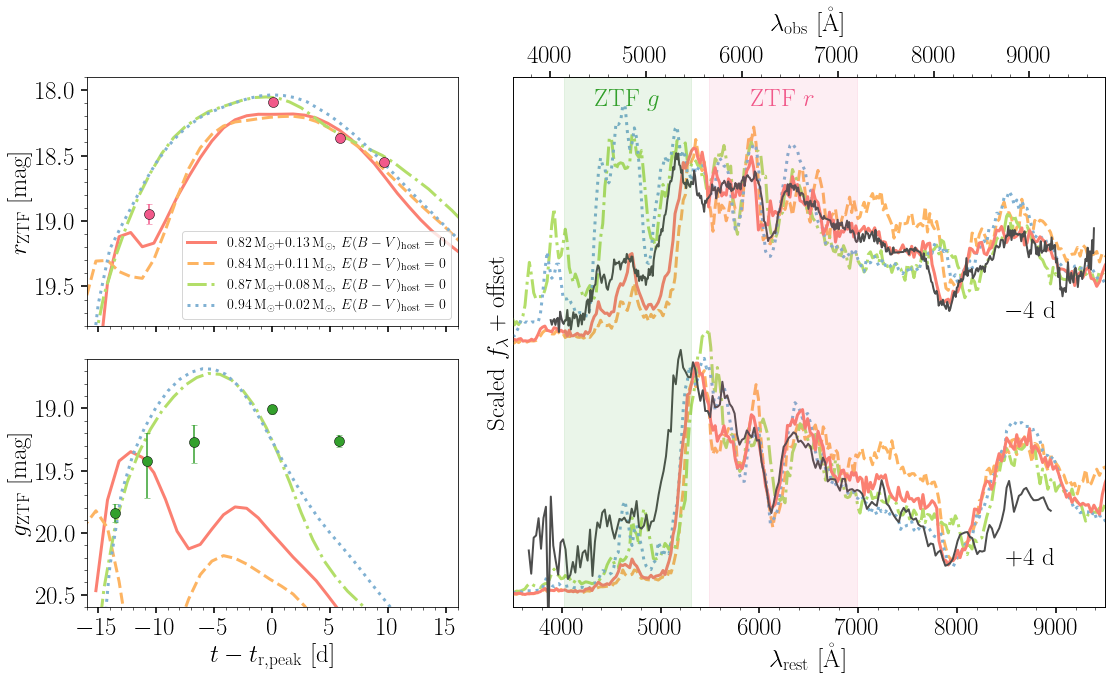

In [218]:
cmap = cm.get_cmap('Set3', 15)
colors = [cmap(i) for i in [4, 6, 7, 5]]
lstyle = ['-', '--', '-.', ':']

models = glob.glob('../../Mtot0.95/*paper*.h5')
models.sort()

fig, ax1, ax2, ax3 = compare_lc_spec(models,
                                     colors,
                                     lstyle,
                                     h=1.25,
                                     ebv_gal=0.404,
                                     ebv_host_list=[0, 0, 0, 0],
                                     t_rmaxs=[16.8, 18.8, 21.1, None])
ax2.set_ylim(19.8, 17.9)
ax1.set_ylim(20.6, 18.6)
plt.savefig('../paper/figures/model_0_95.pdf', bbox_inches='tight')
plt.show()


### Host extinction

0.87 0.13 [19.6]
0.90 0.10 [20.6]


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/3058013104.py:21: RuntimeWarning: invalid value encountered in double_scalars
  flux_err_Jy = flux_err / flux * flux_Jy
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/3058013104.py:28: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5 * np.log10(flux / 3631.1)


0.95 0.05 [23.5]
1.00 0.02 [20.5]


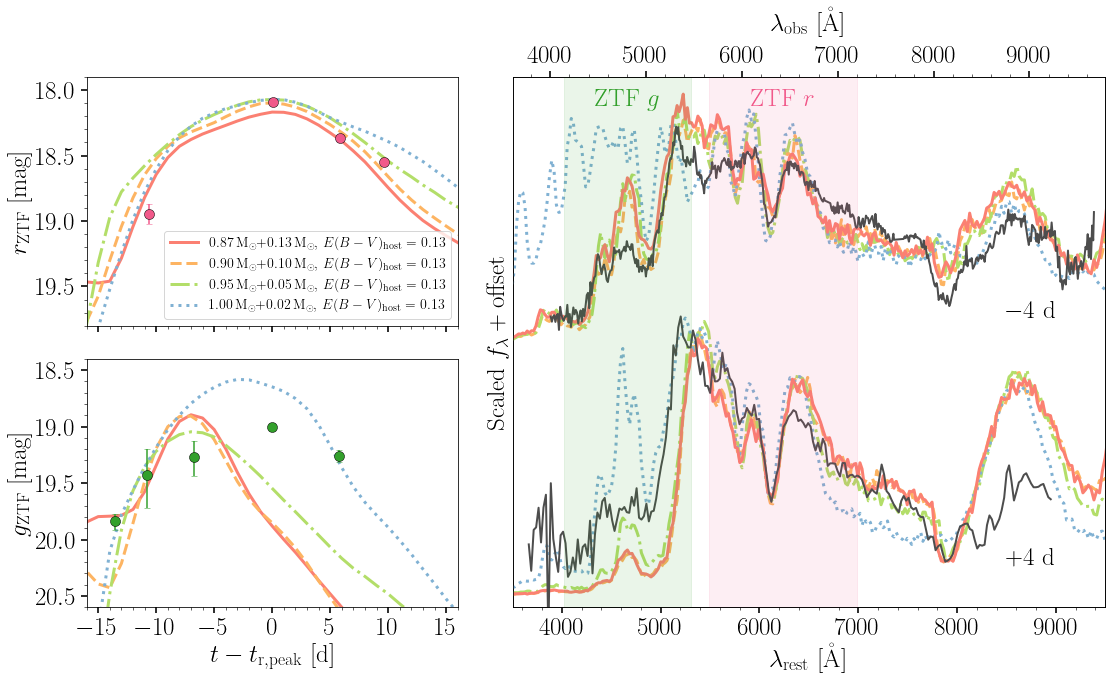

In [219]:
cmap = cm.get_cmap('Set3', 15)
colors = [cmap(i) for i in [4, 6, 7, 5]]
lstyle = ['-', '--', '-.', ':']

models = glob.glob('../../Mtot1.0/*paper*.h5')
models.sort()

fig, ax1, ax2, ax3 = compare_lc_spec(models,
                                     colors,
                                     lstyle,
                                     h=1.1,
                                     ebv_gal=0.404,
                                     ebv_host_list=[0.13, 0.13, 0.13, 0.13],
                                     t_rmaxs=[])
ax2.set_ylim(19.8, 17.9)
ax1.set_ylim(20.6, 18.4)
plt.savefig('../paper/figures/model_1_0.pdf', bbox_inches='tight')
plt.show()

### Optimal models

0.82 0.13 [18.6]
0.87 0.13 [19.6]


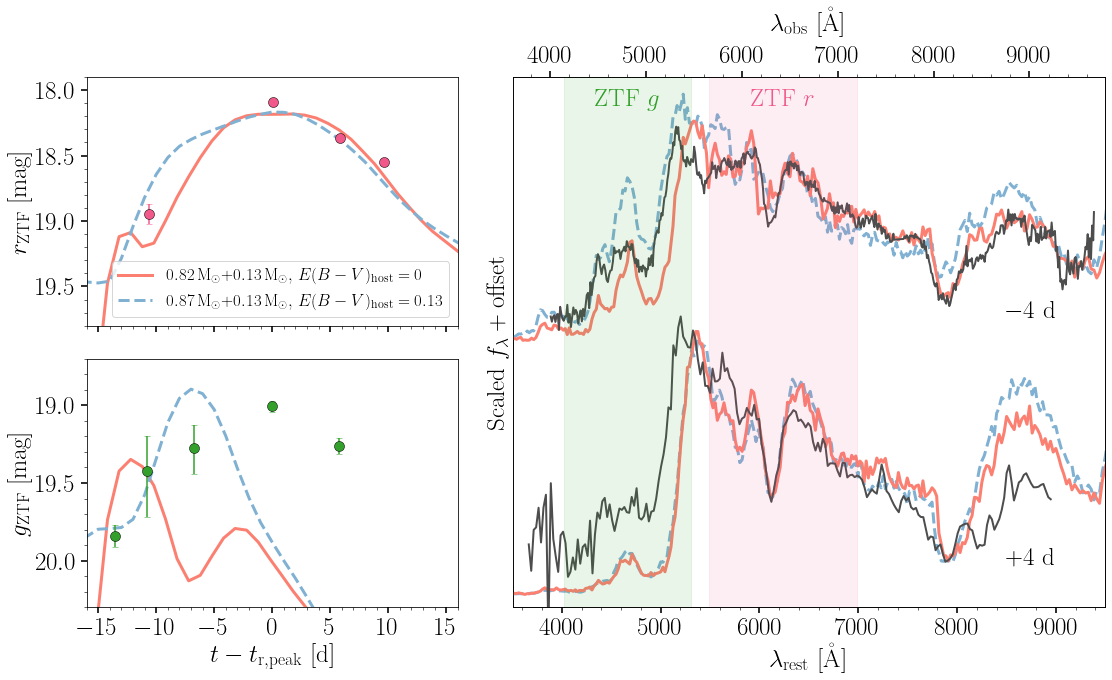

In [220]:
cmap = cm.get_cmap('Set3', 15)
colors = [cmap(i) for i in [4, 5]]
lstyle = ['-', '--']

models = glob.glob('../../Mtot*/*paper.h5')
models.sort()

fig, ax1, ax2, ax3 = compare_lc_spec(models,
                                     colors,
                                     lstyle,
                                     h=1.1,
                                     ebv_gal=0.404,
                                     ebv_host_list=[0, 0.13], t_rmaxs=[16.8, None])
ax2.set_ylim(19.8, 17.9)
ax1.set_ylim(20.3, 18.7)
plt.savefig('../paper/figures/model.pdf', bbox_inches='tight')
plt.show()

## g-r

In [222]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/g_r_Bulla20.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [223]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    if not flux:
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        unc1, unc2 = X[:, 3:], Y[:, 3:]
        f1, f2 = 10**(-0.4 * mag1), 10**(-0.4 * mag2)
        f_unc1 = (10**(-0.4 *
                       (mag1 - unc1[:, 0])) - 10**(-0.4 *
                                                   (mag1 + unc1[:, 1]))) / 2
        f_unc2 = (10**(-0.4 *
                       (mag2 - unc2[:, 0])) - 10**(-0.4 *
                                                   (mag2 + unc2[:, 1]))) / 2
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [224]:
# 11fe
fe_lc = Table.read('11fe.csv')
fe_lc = fe_lc[~np.isnan(fe_lc['e_magnitude'])]
fe_lc['Phase'] = (fe_lc['time'] - 55816.6) / (1 + 0.0008)
fe_lc['Phase_fl'] = (fe_lc['time'] - 55796.687) / (1 + 0.0008)
fe_lc = fe_lc[~fe_lc['e_magnitude'].mask]

fe_g = fe_lc[fe_lc['band'] == 'g']
fe_r = fe_lc[fe_lc['band'] == 'r']

distmod = 29.04 #\pm 0.19

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.0077

fe_g['Mag'] = fe_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
fe_r['Mag'] = fe_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([fe_g['Phase'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase'], fe_r['Mag'], fe_r['e_magnitude']]).T
fe_g_bin = data_binning(X, size=0.5)
fe_r_bin = data_binning(Y, size=0.5)

X = np.array([fe_g['Phase_fl'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase_fl'], fe_r['Mag'], fe_r['e_magnitude']]).T
X = data_binning(X, size=0.5)
Y = data_binning(Y, size=0.5)
dT_fe, dmag_fe, Unc_fe = mag1_mag2(X, Y, bin_size=0.8)

In [225]:
# 11fe
distmod = 29.04 #\pm 0.19
fe_g_syn = np.loadtxt('SN2011fe_g_synthetic.dat')
fe_g_syn[:, 0] = (fe_g_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_g_syn[:, 1] = fe_g_syn[:, 1] - distmod
fe_r_syn = np.loadtxt('SN2011fe_r_synthetic.dat')
fe_r_syn[:, 0] = (fe_r_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_r_syn[:, 1] = fe_r_syn[:, 1] - distmod
fe_g_r_syn = np.loadtxt('SN2011fe_g_r_synthetic.dat')
fe_g_r_syn[:, 0] = (fe_g_r_syn[:, 0] - 55796.687) / (1 + 0.0008) # w.r.t fl

In [226]:
# 16jhr
jhr_lc = Table.read('16jhr.csv')
jhr_lc = jhr_lc[~np.isnan(jhr_lc['e_magnitude'])]
jhr_lc['Phase'] = (jhr_lc['time'] - 57504) / (1 + 0.11737)
jhr_lc['Phase_fl'] = (jhr_lc['time'] - 57482) / (1 + 0.11737)
jhr_lc = jhr_lc[~jhr_lc['e_magnitude'].mask]

In [227]:
jhr_g = jhr_lc[(jhr_lc['band'] == 'g')]
jhr_r = jhr_lc[(jhr_lc['band'] == 'r')]

distmod = 38.69 # Jiang+2017, method part

leff_g = 4816.12  #AA
leff_r = 6234.11  #AA
rv = 3.1
ebv = 0.0263

jhr_g['Mag'] = jhr_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
jhr_r['Mag'] = jhr_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([jhr_g['Phase'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
jhr_g_bin = data_binning(X, size=0.5)
jhr_r_bin = data_binning(Y, size=0.5)

X = np.array([jhr_g['Phase_fl'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase_fl'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
X = data_binning(X, size=1)
Y = data_binning(Y, size=1)
dT_jhr, dmag_jhr, Unc_jhr = mag1_mag2(X, Y, bin_size=1)
dmag_jhr = dmag_jhr[dT_jhr > 1]
Unc_jhr = Unc_jhr[dT_jhr > 1]
dT_jhr = dT_jhr[dT_jhr > 1]

In [228]:
# 18byg
byg_lc = Table.read('18byg.txt', format='ascii')
byg_lc = byg_lc[~np.isnan(byg_lc['e_omag'])]
byg_r = byg_lc[byg_lc['Filter'] == 'r']
byg_g = byg_lc[byg_lc['Filter'] == 'g']

In [229]:
z_byg = 0.066
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod0 = cosmo.distmod(z=z_byg)

beta1 = z_byg
beta2 = ((1 + z_byg)**2 - 1) / ((1 + z_byg)**2 + 1)

DL = np.loadtxt('18byg_peculiar.dat')[6]  #H0 = 70
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.011

byg_g['Mag'] = byg_g['omag'] - distmod.value - calALambda(leff_g, rv, ebv)
byg_r['Mag'] = byg_r['omag'] - distmod.value - calALambda(leff_r, rv, ebv)

In [230]:
tfl_byg = 58233.198 + 9.07 / 2

#photometry
X = np.array([(byg_g['MJD'] - tfl_byg) / (1 + 0.066), byg_g['Mag'],
              byg_g['e_omag']]).T
Y = np.array([(byg_r['MJD'] - tfl_byg) / (1 + 0.066), byg_r['Mag'],
              byg_r['e_omag']]).T
dT_byg, dmag_byg, Unc_byg = mag1_mag2(X, Y, bin_size=1)

#synthetic
color_byg = Table.read('color/gr_18byg.txt', format='ascii')
gr_byg = color_byg[color_byg['Filt'] == 'gr']
tp_byg = byg_r['MJD'][np.argmin(byg_r['omag'])]
gr_byg['Phase'] = (gr_byg['Epoch'] + tp_byg - tfl_byg) / (1 + 0.066)
dT_byg = np.append(dT_byg, gr_byg['Phase'])
dmag_byg = np.append(dmag_byg, gr_byg['Color'])
Unc_byg = np.append(Unc_byg, gr_byg['Err'])

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/845862577.py:48: RuntimeWarning: overflow encountered in power
  (mag1 - unc1[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/845862577.py:51: RuntimeWarning: overflow encountered in power
  (mag2 - unc2[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/845862577.py:64: RuntimeWarning: invalid value encountered in double_scalars
  t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/845862577.py:69: RuntimeWarning: divide by zero encountered in log10
  -2.5 * np.log10(f12 / (f12 + f12unc)))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_35544/845862577.py:70: RuntimeWarning: invalid value encountered in log10
  Unc_l = np.append(Unc_l, -2.5 * np.log10(


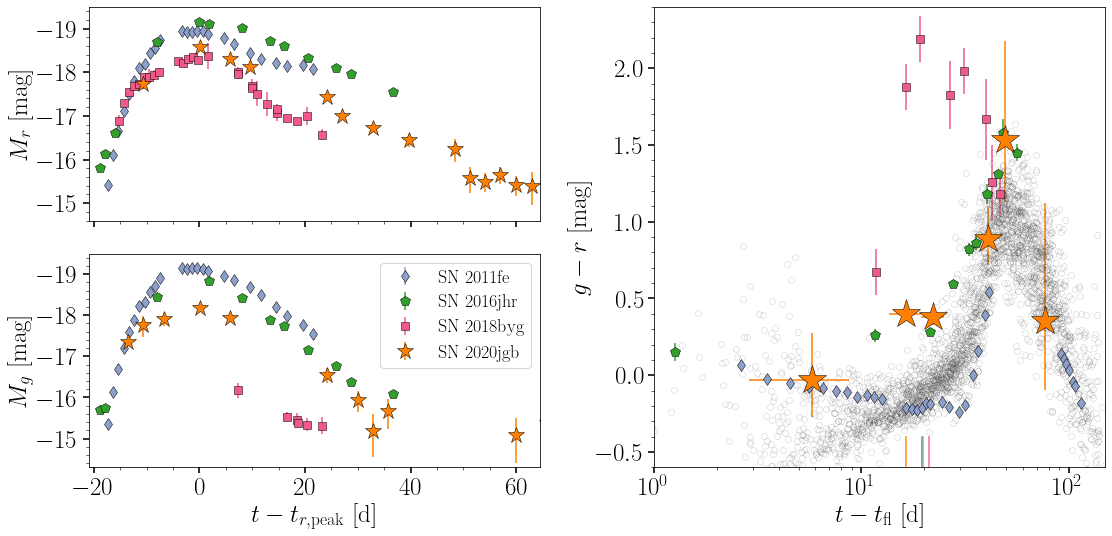

In [270]:
f = plt.figure(figsize=(16, 8))
ax2 = plt.subplot(2, 2, 1)
ax1 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

col_11fe = color_map['blue']
col_16jhr = color_map['green']
col_18byg = color_map['magenta']
col_20jgb = color_map['orange']

#11fe
ax1.errorbar(fe_g_syn[:, 0],
             fe_g_syn[:, 1],
             yerr=fe_g_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe,
             label='$\mathrm{SN\ 2011fe}$')
ax2.errorbar(fe_r_syn[:, 0],
             fe_r_syn[:, 1],
             yerr=fe_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)

#16jhr
ax1.errorbar(jhr_g_bin[:, 0],
             jhr_g_bin[:, 1],
             yerr=jhr_g_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr,
             label='$\mathrm{SN\ 2016jhr}$')
ax2.errorbar(jhr_r_bin[:, 0],
             jhr_r_bin[:, 1],
             yerr=jhr_r_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)

#18 byg
ax1.errorbar(byg_g['Phase'],
             byg_g['Mag'],
             yerr=byg_g['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg,
             label='$\mathrm{SN\ 2018byg}$')
ax2.errorbar(byg_r['Phase'],
             byg_r['Mag'],
             yerr=byg_r['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)

X2 = np.loadtxt('SN2020jgb_ZTF_g_snr2.dat')
Y2 = np.loadtxt('SN2020jgb_ZTF_r_snr2.dat')

dT, dmag, Unc = mag1_mag2(X2, Y2, bin_size=1, flux=True)
Mag_pred, Mag_pred_unc = [], []
for x2, ax in zip([X2, Y2], [ax1, ax2]):
    t = x2[x2[:, 2] > 0, 0]
    mag = x2[x2[:, 2] > 0, 1].copy()
    mag_unc = x2[x2[:, 2] > 0, 3:].T.copy()
    t_lim = x2[x2[:, 2] < 0, 0].copy()
    lim = x2[x2[:, 2] < 0, 1].copy()

    ax.errorbar((t - tp) / (1 + z),
                mag,
                yerr=mag_unc,
                fmt='*',
                markersize=17,
                markeredgecolor='k',
                markeredgewidth=.5,
                color=col_20jgb,
                label='$\mathrm{SN\ 2020jgb}$')

    ax.set_xlim(-21, 64.5)
    ax.set_yticks([-15, -16, -17, -18, -19])

ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$M_r\ \mathrm{[mag]}$')

ax1.legend(prop={'size': 18})
ax1.set_xlabel(r'$t-t_{r,\mathrm{peak}}\ [\mathrm{d}]$')
ax1.set_ylabel(r'$M_g\ \mathrm{[mag]}$')

ax2.set_ylim(-19.5, -14.6)
ax1.set_ylim(-19.5, -14.3)
ax1.invert_yaxis()
ax2.invert_yaxis()

ax3.errorbar(fe_g_r_syn[:, 0],
             fe_g_r_syn[:, 1],
             yerr=fe_g_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)
ax3.errorbar(dT_jhr,
             dmag_jhr,
             yerr=Unc_jhr,
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)
ax3.errorbar(dT_byg,
             dmag_byg,
             yerr=Unc_byg,
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)
ax3.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='*',
             markersize=30,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_20jgb)
ax3.set_ylim(-0.6, 2.4)
ax3.set_xlim(1, 150)
ax3.set_ylabel('$g-r\ \mathrm{[mag]}$')
ax3.set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax3.set_xscale('log')

ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
         color=col_20jgb,
         alpha=.9,
         zorder=-10)
ax3.plot([(tp_byg - tfl_byg) / (1 + 0.066), (tp_byg - tfl_byg) / (1 + 0.066)],
         [-0.7, -0.4],
         color=col_18byg,
         alpha=.9,
         zorder=-10)
ax3.plot([(57504 - 57482) / (1 + 0.11737), (57504 - 57482) / (1 + 0.11737)],
         [-0.7, -0.4],
         color=col_16jhr,
         alpha=.9,
         zorder=-10)
ax3.plot([(55816.6 - 55796.687) / (1 + 0.0008),
          (55816.6 - 55796.687) / (1 + 0.0008)], [-0.7, -0.4],
         color=col_11fe,
         alpha=.9,
         zorder=-10)

# K-corrections
'''ax3.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=6,
         alpha=0.3)'''

# No K-corrections
ebv_sbv = pd.read_csv('./color/early18ia/ebv_sbv.txt', sep=' ')
lcs = glob.glob('./color/early18ia/*dat')
lcs.sort()
t_tfl_list = fits.getdata('./color/Bulla20.fit')

for lc in lcs:
    name = lc.split('/')[-1].split('.')[0]
    if name in gr_population.iloc[normal_ia].SN.unique():
        t_tfl = t_tfl_list['t-tfl'][t_tfl_list['ZTF'] == name]
        raw = pd.read_csv(lc, sep=' ')
        lc_g = np.array(raw)[:, :-1][raw['fid'] == 1]
        lc_r = np.array(raw)[:, :-1][raw['fid'] == 2]
        g_r = mag1_mag2(lc_g, lc_r)
        ebv = np.array(ebv_sbv['ebv'])[ebv_sbv['sn'] == name][0]
        ax3.plot(g_r[0] - g_r[0][0] + t_tfl,
                 g_r[1] - (calALambda(wv=leff_g, EBV=ebv, RV=3.1) -
                           calALambda(wv=leff_r, EBV=ebv, RV=3.1)),
                 'o',
                 color='None',
                 mec='0.2',
                 mew=0.4,
                 ms=6,
                 alpha=0.3)

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.savefig('../paper/figures/photometry.pdf', bbox_inches='tight')

In [50]:
def decline_rate(data, post=20):
    t = data[:, 0]
    mag = data[:, 1]
    tp = t[np.argmin(mag)]
    magp = np.min(mag)
    ref = np.argmin(np.abs(t - tp - post))
    rate = (mag[ref] - magp) / (t[ref] - tp)
    print(
        'closest obs: {:.2f}, rate: {:.3f} mag/d, Delta M{:.0f}: {:.2f}'.format(
            t[ref] - tp, rate, post, rate * post))

In [51]:
decline_rate(fe_g_bin)
decline_rate(jhr_g_bin)
decline_rate(np.array([byg_g['Phase'], byg_g['Mag']]).T, post=12)
decline_rate(X1) #20jgb

closest obs: 19.94, rate: 0.062 mag/d, Delta M20: 1.24
closest obs: 18.79, rate: 0.089 mag/d, Delta M20: 1.79
closest obs: 11.29, rate: 0.070 mag/d, Delta M12: 0.84
closest obs: 24.88, rate: 0.066 mag/d, Delta M20: 1.32


In [52]:
decline_rate(fe_g_syn, post=-14)
decline_rate(jhr_g_bin, post=-14)
decline_rate(X2, post=-14) #20jgb

closest obs: -13.89, rate: -0.274 mag/d, Delta M-14: 3.83
closest obs: -9.84, rate: -0.041 mag/d, Delta M-14: 0.57
closest obs: -13.95, rate: -0.060 mag/d, Delta M-14: 0.84
